In [ ]:
%reset

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image

In [113]:
DEBUG = False

data_path = "Data/CK:CK+/CK+/cohn-kanade-images"
label_path = "Data/CK:CK+/CK+/Emotion"

d = []
for root, dirs, files in os.walk(data_path):
    
    sorted_filtered_files = np.array(sorted(list(filter(lambda x: x.startswith('S'), files))))
    if len(sorted_filtered_files) < 1:
        continue
        
    neutral_expr_path = os.path.join(root,sorted_filtered_files[0])
    other_expression_path = os.path.join(root,sorted_filtered_files[-1])
    
    neutral_expr = np.asarray(Image.open(neutral_expr_path).convert('L').resize((128,98))).astype('float64') / 255
    other_expr = np.asarray(Image.open(other_expression_path).convert('L').resize((128,98))).astype('float64') / 255
    
    splitted_file = sorted_filtered_files[0].split("_")
    subject = splitted_file[0]
        
    cur_labels_dir_path = os.path.join(label_path, splitted_file[0], splitted_file[1])

    if not os.path.isdir(cur_labels_dir_path):
        continue

    cur_labels_files = os.listdir(cur_labels_dir_path)
    if len(cur_labels_files) == 1:
        cur_labels_path = os.path.join(cur_labels_dir_path,cur_labels_files[0])
        if DEBUG: print("Label path: ",str(cur_labels_path))

        if os.path.exists(cur_labels_path):
            cur_label = int(np.loadtxt(cur_labels_path))

    if DEBUG: print("\tLabel: ",cur_label)
        
    ## TODO: !Expression! label to one hot encoding!
    d.append({"subject" : subject, "neutral_expression": neutral_expr, "other_expression": other_expr, "label": cur_label})

data = pandas.DataFrame(d)

In [114]:
print(data.shape)
print(data.columns)

(582, 4)
Index(['label', 'neutral_expression', 'other_expression', 'subject'], dtype='object')


In [150]:
class four_layer_net(nn.Module):
    
    def __init__(self, act_type, input_size,
                 hidden1_size, hidden2_size, hidden3_size, output_size):
        super(four_layer_net, self).__init__()
        
        self.layer1 = nn.Linear(input_size, hidden1_size, bias=True)
        self.layer2 = nn.Linear(hidden1_size, hidden2_size, bias=True)        
        self.layer3 = nn.Linear(hidden2_size, hidden3_size, bias=True)        
        self.layer4 = nn.Linear(hidden3_size, output_size, bias=True)
        
        self.activation = torch.relu if act_type == "relu" else torch.tanh

    def forward(self, x):
        
        z1 = self.activation(self.layer1(x));
        z2 = self.activation(self.layer2(z1));
        z3 = self.activation(self.layer3(z2));
        z4 = self.activation(self.layer4(z3));
        
        return z4

In [123]:
def bhook(module, grad_inp, grad_out):
    print(module, grad_inp, grad_out)

In [159]:
def train_net(net, num_iter, net_layers, train_data, train_label, bs=25, u=10e-2):
    
    losses = list()
    
    # make the criterion
    criterion = nn.MSELoss() # complete here

    # make the SGD optimizer. 
    optimizer=torch.optim.SGD(net.parameters(),lr=u)    
    
    prev = []
    for iter in range(1,num_iter+1):        
        # Set dL/dU, dL/dV, dL/dW to be filled with zeros
        optimizer.zero_grad()

        # create a minibatch
        indices=torch.LongTensor(bs).random_(0, train_data.size()[0])
        minibatch_data = train_data[indices, :]
        minibatch_label = train_label[indices]

        # reshape the minibatch
        inputs = minibatch_data.view(bs,net_layers[0]) 
    #     inputs = minibatch_data.view(train_data.size()[0], 28*28)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net
    #     print("#EPOCH", iter)
        net.cur_labels = minibatch_label
        scores = net (inputs)

        # Compute the average of the losses of the data points in the minibatch
#         print(minibatch_label.shape[1],scores.shape)
        loss = criterion(scores, minibatch_label.view(bs, minibatch_label.shape[1] * minibatch_label.shape[2]))

        # backward pass to compute dL/dU, dL/dV and dL/dW    
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        
        print("Epoch [{}/{}], Loss: {}".format(iter,num_iter,loss))
        losses.append(loss.item())

    return losses

In [152]:
num_pixels = 128 * 98
# n_in, n_h1, n_h2, n_out = num_pixels, num_pixels, num_pixels, num_pixels
net_layers = [num_pixels,num_pixels//2,num_pixels//4,num_pixels//2, num_pixels]
network = four_layer_net('relu', *net_layers)

In [153]:
train_data = data.loc[:2328//2, "other_expression"]
train_label = data.loc[:2328//2, "neutral_expression"]
test_data = data.loc[2328//2: , "other_expression"]
test_label = data.loc[2328//2: , "neutral_expression"]

In [164]:
num_iter = 150
bs = 100
learning_rate = 10e-1
losses = train_net(network, num_iter, net_layers, torch.FloatTensor(train_data), torch.FloatTensor(train_label), bs, learning_rate)

Epoch [1/150], Loss: 0.1086830198764801
Epoch [2/150], Loss: 0.10107257962226868
Epoch [3/150], Loss: 0.10899582505226135
Epoch [4/150], Loss: 0.10316837579011917
Epoch [5/150], Loss: 0.10656122863292694
Epoch [6/150], Loss: 0.10525420308113098
Epoch [7/150], Loss: 0.09736048430204391
Epoch [8/150], Loss: 0.10548064112663269
Epoch [9/150], Loss: 0.10519448667764664
Epoch [10/150], Loss: 0.10223154723644257
Epoch [11/150], Loss: 0.11122899502515793
Epoch [12/150], Loss: 0.10278740525245667
Epoch [13/150], Loss: 0.10495566576719284
Epoch [14/150], Loss: 0.10730163753032684
Epoch [15/150], Loss: 0.10190748423337936
Epoch [16/150], Loss: 0.096222884953022
Epoch [17/150], Loss: 0.10594676434993744
Epoch [18/150], Loss: 0.10316833853721619
Epoch [19/150], Loss: 0.10197710245847702
Epoch [20/150], Loss: 0.10226080566644669
Epoch [21/150], Loss: 0.09898274391889572
Epoch [22/150], Loss: 0.10577622801065445
Epoch [23/150], Loss: 0.11141909658908844
Epoch [24/150], Loss: 0.10171953588724136
Epoc

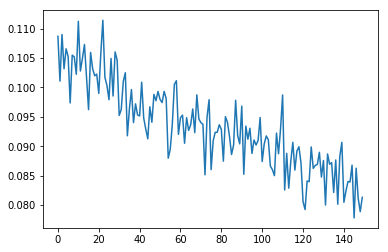

In [165]:
plt.plot(losses)

In [1]:
im_id = 99

In [217]:
predicted = network.forward(torch.FloatTensor(data.iloc[im_id]['other_expression']).view(98*128)).view(98,128)

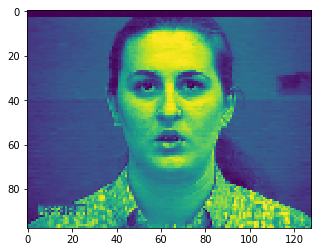

In [218]:
plt.imshow(data.iloc[im_id]['other_expression'])

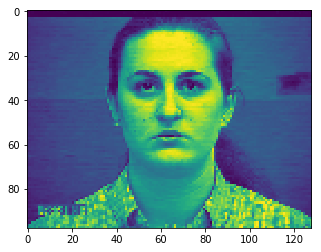

In [219]:
plt.imshow(data.iloc[im_id]['neutral_expression'])

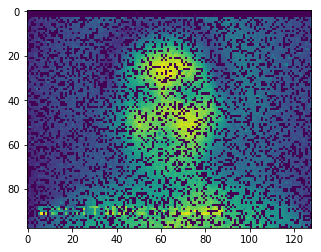

In [220]:
plt.imshow((predicted.detach().numpy()))